In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('data/crime/crime_merged_data_cleaned.csv')


postcode = pd.read_csv('data/LSOA/Postcode_to_LSOA.csv',encoding='latin')

housing_data = pd.read_csv('data/HousingPrice/HousingPriceCleaned/profiled_data.csv')

fist_merge = postcode.merge(housing_data,left_on='pcd8',right_on='Post Code', how='inner')
fist_merge = fist_merge[['Post Code', 'City', 'District', 'County','lsoa11cd']]
fist_merge.rename(columns={'lsoa11cd': 'LSOA'}, inplace=True)


/var/folders/gx/nb4lbx_x39q8jmdpw0hfl6sh0000gn/T/ipykernel_19271/1771096418.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/crime/crime_merged_data_cleaned.csv')
/var/folders/gx/nb4lbx_x39q8jmdpw0hfl6sh0000gn/T/ipykernel_19271/1771096418.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  postcode = pd.read_csv('data/LSOA/Postcode_to_LSOA.csv',encoding='latin')


In [3]:
final_merge = fist_merge.merge(data,left_on='LSOA', right_on='LSOA code', how='inner' )
final_merge.drop(columns={'LSOA'}, inplace=True)
final_merge.head(5)

,Post Code,City,District,County,Month,Falls within,Crime type,LSOA code
0,BD10 0AA,BRADFORD,BRADFORD,WEST YORKSHIRE,2022-11,West Yorkshire Police,Criminal damage and arson,E01010684
1,BD10 0AA,BRADFORD,BRADFORD,WEST YORKSHIRE,2022-11,West Yorkshire Police,Drugs,E01010684
2,BD10 0AA,BRADFORD,BRADFORD,WEST YORKSHIRE,2022-11,West Yorkshire Police,Vehicle crime,E01010684
3,BD10 0AA,BRADFORD,BRADFORD,WEST YORKSHIRE,2022-11,West Yorkshire Police,Vehicle crime,E01010684
4,BD10 0AA,BRADFORD,BRADFORD,WEST YORKSHIRE,2022-11,West Yorkshire Police,Violence and sexual offences,E01010684


In [4]:
final_merge['Year'] = final_merge['Month'].apply(lambda x: int(x.split('-')[0]))
crime_type_totals = final_merge.groupby(['District', 'Year', 'Crime type'])['Crime type'].count().reset_index(name='Total')
crime_type_totals.head(20)

,District,Year,Crime type,Total
0,BRADFORD,2021,Anti-social behaviour,257228
1,BRADFORD,2021,Bicycle theft,3778
2,BRADFORD,2021,Burglary,87112
3,BRADFORD,2021,Criminal damage and arson,154572
4,BRADFORD,2021,Drugs,40638
5,BRADFORD,2021,Other crime,38350
6,BRADFORD,2021,Other theft,84508
7,BRADFORD,2021,Possession of weapons,10048
8,BRADFORD,2021,Public order,231994
9,BRADFORD,2021,Robbery,8636


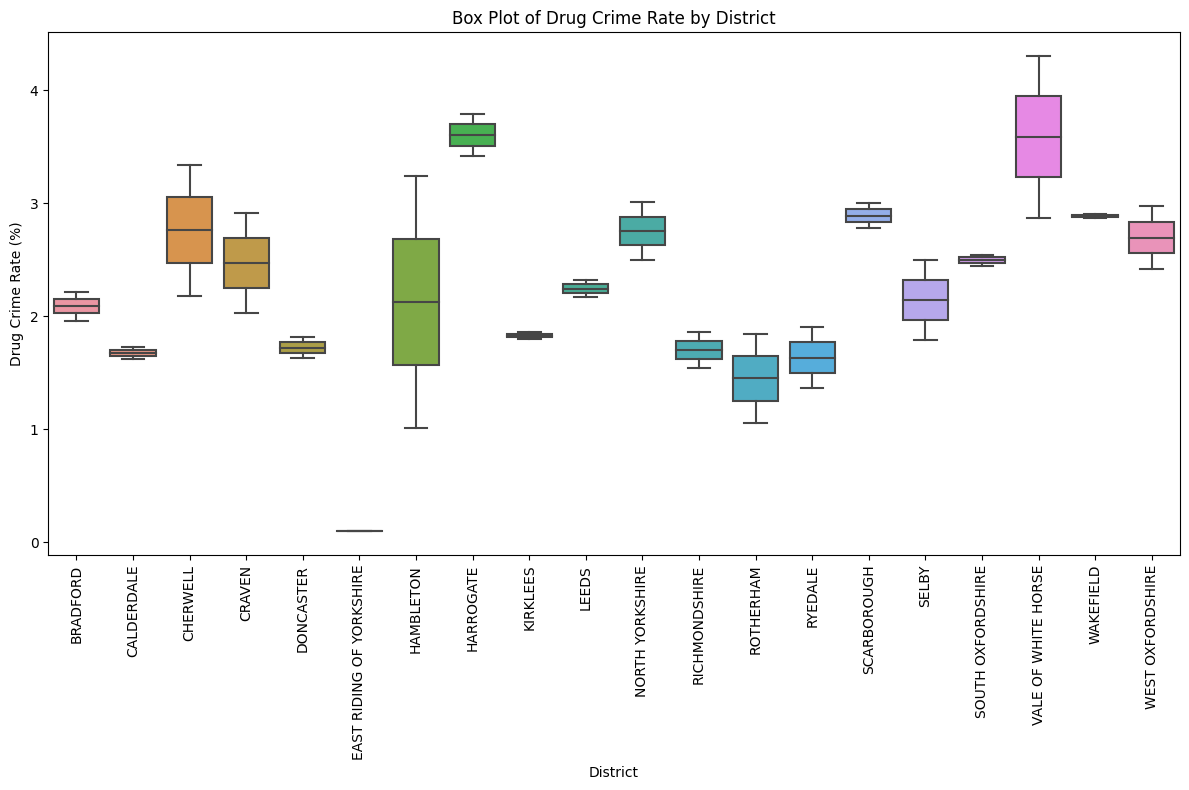

In [5]:
total_crimes = crime_type_totals.groupby(['District', 'Year'])['Total'].sum().reset_index(name='Total All Crimes')

# Merge the total crime data with the 'crime_type_totals' DataFrame
merged_data = pd.merge(crime_type_totals, total_crimes, on=['District', 'Year'])

# Calculate the rate of 'Drugs' crimes for each district and year
merged_data['Drug Crime Rate'] = (merged_data['Total'] / merged_data['Total All Crimes']) * 100

# Create a boxplot using seaborn
plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.boxplot(data=merged_data[merged_data['Crime type'] == 'Drugs'], x='District', y='Drug Crime Rate')
plt.xlabel('District')
plt.ylabel('Drug Crime Rate (%)')
plt.title('Box Plot of Drug Crime Rate by District')
plt.xticks(rotation=90, fontsize=10)  # Adjust the font size and rotation of x-axis labels
plt.yticks(fontsize=10)  # Adjust the font size of y-axis labels
plt.tight_layout()
plt.show()

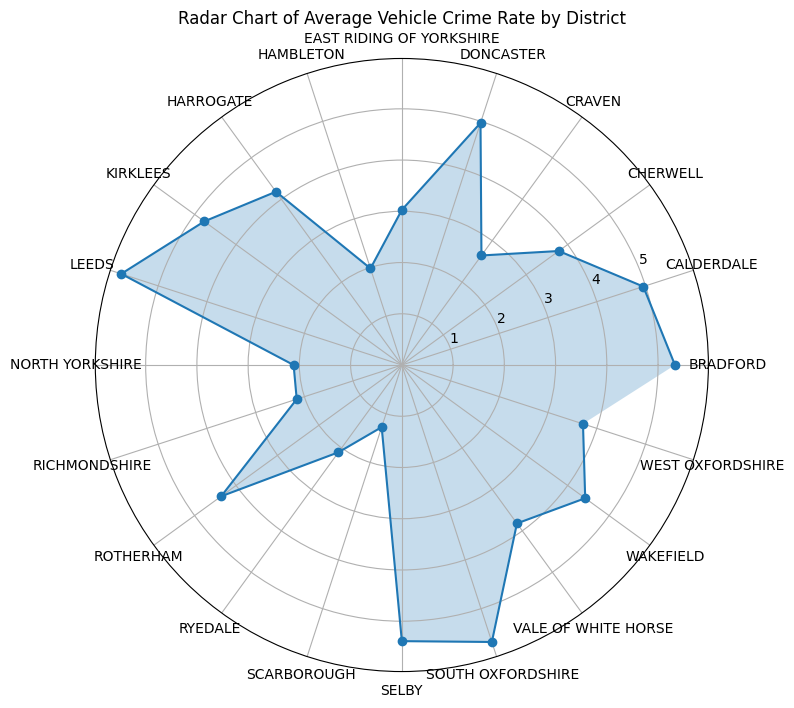

In [6]:
merged_data['Vehicle Crime Rate'] = (merged_data['Total'] / merged_data['Total All Crimes']) * 100

# Filter for 'Vehicle crimes'
vehicle_data = merged_data[merged_data['Crime type'] == 'Vehicle crime']

# Get unique districts
districts = vehicle_data['District'].unique()

# Prepare data for radar chart
data_values = []

for district in districts:
    district_values = vehicle_data[vehicle_data['District'] == district]['Vehicle Crime Rate'].mean()
    data_values.append(district_values)

# Create radar chart
plt.figure(figsize=(8, 8))

angles = np.linspace(0, 2 * np.pi, len(districts), endpoint=False)

# Plot data
ax = plt.subplot(111, polar=True)
ax.plot(angles, data_values, marker='o')
ax.fill(angles, data_values, alpha=0.25)

# Set the number of locator locations to match the number of labels
ax.set_xticks(angles)
ax.set_xticklabels(districts, fontsize=10)

plt.yticks(fontsize=10)
plt.title('Radar Chart of Average Vehicle Crime Rate by District')
plt.tight_layout()
plt.show()

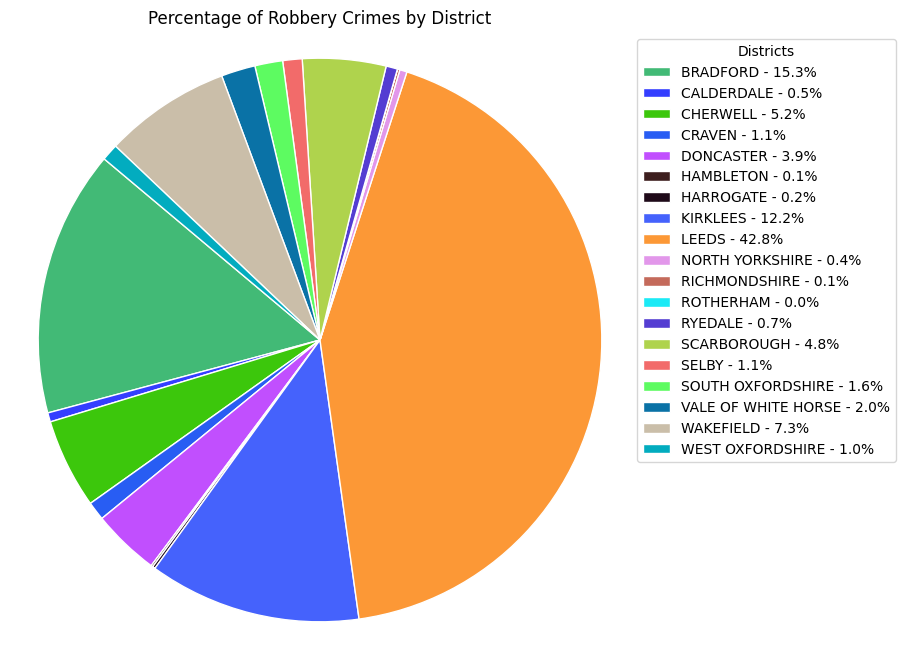

In [7]:
robbery_data = merged_data[merged_data['Crime type'] == 'Robbery']

district_robberies = robbery_data.groupby('District')['Total'].sum()
total_robberies = district_robberies.sum()
district_percentages = (district_robberies / total_robberies) * 100
num_districts = len(district_robberies)
unique_colors = ['#' + '%06x' % random.randint(0, 0xFFFFFF) for _ in range(num_districts)]

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(district_robberies, colors=unique_colors,
                                   autopct='', startangle=140, pctdistance=0.85,
                                   wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('Percentage of Robbery Crimes by District')
plt.axis('equal') 

legend_labels = ['{} - {:.1f}%'.format(label, percentage) for label, percentage in zip(district_percentages.index, district_percentages)]
plt.legend(wedges, legend_labels, title='Districts', loc='upper left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [8]:
population_data = pd.read_csv('data/Population/Cleaned_Town_population.csv')
population_data_filtered= population_data[['PostCode','Population2021','Population2022']]
crime_merge = final_merge.copy()
drug_crime_data = crime_merge.merge(population_data_filtered,left_on= 'Post Code', right_on='PostCode', how='inner')

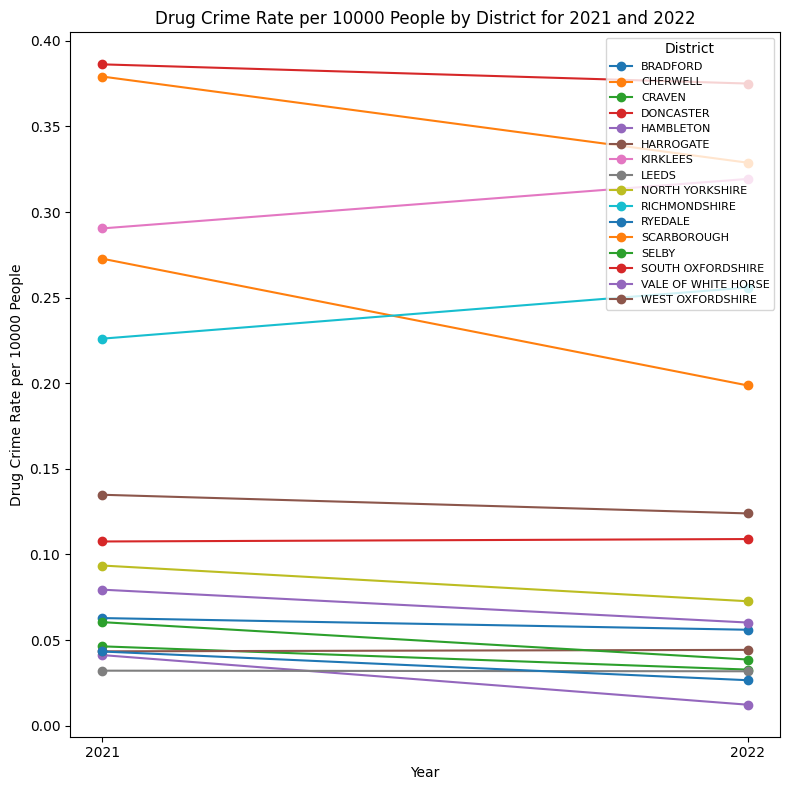

In [55]:

data_2021 = merged_data[(merged_data['Crime type'] == 'Drugs') & (merged_data['Year'] == 2021)]
data_2022 = merged_data[(merged_data['Crime type'] == 'Drugs') & (merged_data['Year'] == 2022)]

populations = drug_crime_data.groupby('District')['Population2022'].sum()

district_drug_rate_2021 = ((data_2021.groupby('District')['Total'].sum() / populations) * 10000).dropna()
district_drug_rate_2022 = ((data_2022.groupby('District')['Total'].sum() / populations) * 10000).dropna()

plt.figure(figsize=(12, 8))

for district in district_drug_rate_2021.index:
    plt.plot([2021, 2022], [district_drug_rate_2021[district], district_drug_rate_2022[district]], marker='o', label=district)

plt.xlabel('Year')
plt.ylabel('Drug Crime Rate per 10000 People')
plt.title('Drug Crime Rate per 10000 People by District for 2021 and 2022')

# Move the legend to the top right and reduce its font size
plt.legend(title='District', fontsize=8, loc='upper right')

plt.xticks([2021, 2022], fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [19]:
drug_all = merged_data[merged_data['Crime type'] == 'Drugs']
drug_all.head()
drug_housing = drug_all.merge(housing_data, on='District',how='inner')
replacement_value = 'YORKSHIRE'
drug_housing['County'] = drug_housing['County'].str.replace('WEST YORKSHIRE', replacement_value, case=False)
drug_housing['County'] = drug_housing['County'].str.replace('EAST RIDING OF YORKSHIRE', replacement_value, case=False)
drug_housing['County'] = drug_housing['County'].str.replace('SOUTH YORKSHIRE', replacement_value, case=False)
drug_housing['County'] = drug_housing['County'].str.replace('NORTH YORKSHIRE', replacement_value, case=False)
grouped_data = drug_housing.groupby('County')

In [21]:
drug_housing_yk = drug_housing[drug_housing['County'].str.contains('Yorkshire', case=False)]
drug_housing_yk.head(10)

drug_housing_ox = drug_housing[drug_housing['County'].str.contains('Oxfordshire', case=False)]
drug_housing_ox.head(10)


,District,Year,Crime type,Total,Total All Crimes,Drug Crime Rate,Vehicle Crime Rate,Price,Post Code,City,County
22702,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,165188,OX16 9HQ,BANBURY,OXFORDSHIRE
22703,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,325000,OX16 1YB,BANBURY,OXFORDSHIRE
22704,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,230000,OX16 0HX,BANBURY,OXFORDSHIRE
22705,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,192000,OX5 3DF,KIDLINGTON,OXFORDSHIRE
22706,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,245000,OX16 9UU,BANBURY,OXFORDSHIRE
22707,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,180000,OX16 1XN,BANBURY,OXFORDSHIRE
22708,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,340000,OX15 4TJ,BANBURY,OXFORDSHIRE
22709,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,242000,OX16 1PU,BANBURY,OXFORDSHIRE
22710,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,230000,OX16 1XD,BANBURY,OXFORDSHIRE
22711,CHERWELL,2021,Drugs,26638,797668,3.339485,3.339485,351000,OX25 1PA,BICESTER,OXFORDSHIRE


In [58]:
model = LinearRegression()

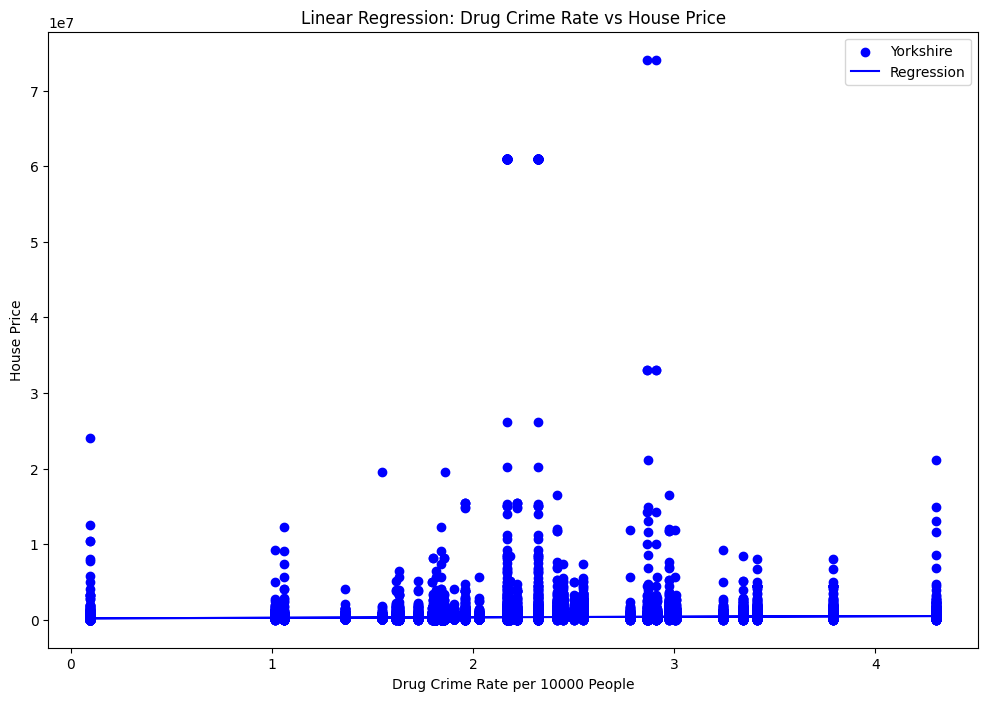

In [59]:
X = drug_housing[['Drug Crime Rate']]
y = drug_housing['Price']


model.fit(X, y)

predicted_prices = model.predict(X)

plt.figure(figsize=(12, 8))
plt.scatter(X, y, label='Yorkshire', color='blue')
plt.plot(X, predicted_prices, color='blue', label='Regression')
plt.xlabel('Drug Crime Rate per 10000 People')
plt.ylabel('House Price')
plt.title('Linear Regression: Drug Crime Rate vs House Price')
plt.legend()
plt.show()

In [35]:
broadband_data = pd.read_csv('data/Broadband/BroadbandCleaned/broadband_filtered_performance_all.csv')
broadband_data = broadband_data.merge(drug_housing, left_on='postcode_space', right_on='Post Code')

broadband_data_yk = broadband_data[broadband_data['County'].str.contains('Yorkshire', case=False)]
broadband_data_yk.head(10)

broadband_data_ox = broadband_data[broadband_data['County'].str.contains('Oxfordshire', case=False)]
broadband_data_ox.head(10)

,postcode_space,Median download speed (Mbit/s),Average download speed (Mbit/s),Maximum download speed (Mbit/s),District,Year,Crime type,Total,Total All Crimes,Drug Crime Rate,Vehicle Crime Rate,Price,Post Code,City,County
30792,OX10 0AL,73.7,75.2,160.00,SOUTH OXFORDSHIRE,2021,Drugs,7786,306022,2.544262,2.544262,160000,OX10 0AL,WALLINGFORD,OXFORDSHIRE
30793,OX10 0AL,73.7,75.2,160.00,SOUTH OXFORDSHIRE,2022,Drugs,7560,309158,2.445352,2.445352,160000,OX10 0AL,WALLINGFORD,OXFORDSHIRE
30794,OX10 0AX,100.0,112.4,350.00,SOUTH OXFORDSHIRE,2021,Drugs,7786,306022,2.544262,2.544262,375000,OX10 0AX,WALLINGFORD,OXFORDSHIRE
30795,OX10 0AX,100.0,112.4,350.00,SOUTH OXFORDSHIRE,2022,Drugs,7560,309158,2.445352,2.445352,375000,OX10 0AX,WALLINGFORD,OXFORDSHIRE
30796,OX10 0BN,26.1,41.4,69.75,SOUTH OXFORDSHIRE,2021,Drugs,7786,306022,2.544262,2.544262,810000,OX10 0BN,WALLINGFORD,OXFORDSHIRE
30797,OX10 0BN,26.1,41.4,69.75,SOUTH OXFORDSHIRE,2022,Drugs,7560,309158,2.445352,2.445352,810000,OX10 0BN,WALLINGFORD,OXFORDSHIRE
30798,OX10 0BP,79.7,151.3,500.00,SOUTH OXFORDSHIRE,2021,Drugs,7786,306022,2.544262,2.544262,245000,OX10 0BP,WALLINGFORD,OXFORDSHIRE
30799,OX10 0BP,79.7,151.3,500.00,SOUTH OXFORDSHIRE,2021,Drugs,7786,306022,2.544262,2.544262,1626000,OX10 0BP,WALLINGFORD,OXFORDSHIRE
30800,OX10 0BP,79.7,151.3,500.00,SOUTH OXFORDSHIRE,2021,Drugs,7786,306022,2.544262,2.544262,730000,OX10 0BP,WALLINGFORD,OXFORDSHIRE
30801,OX10 0BP,79.7,151.3,500.00,SOUTH OXFORDSHIRE,2022,Drugs,7560,309158,2.445352,2.445352,245000,OX10 0BP,WALLINGFORD,OXFORDSHIRE


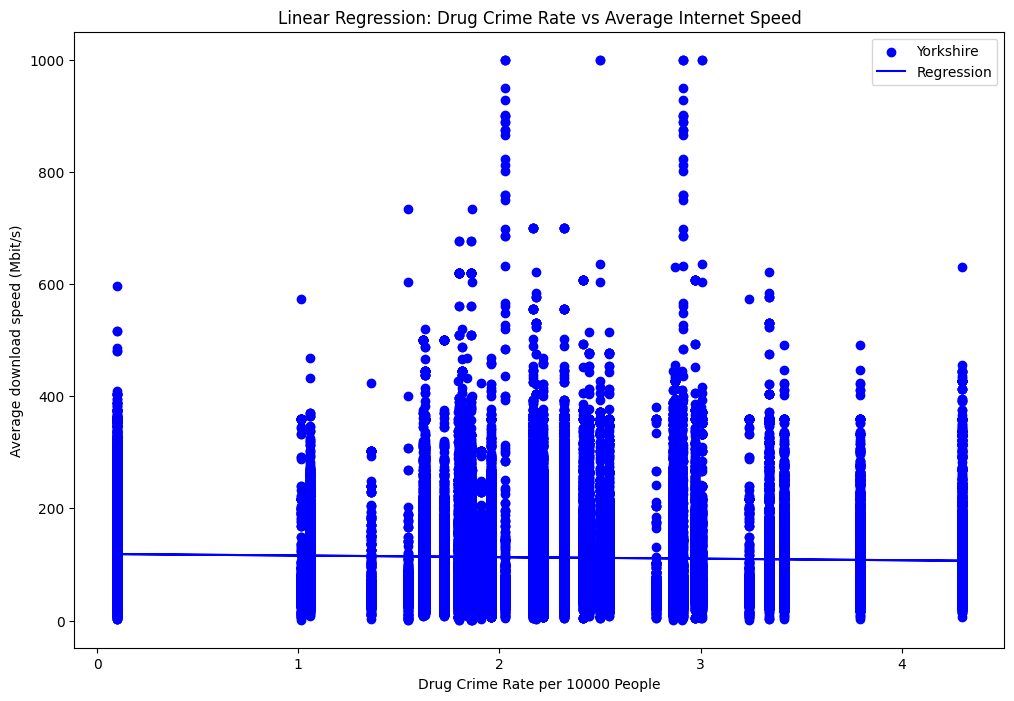

In [60]:
X = broadband_data[['Drug Crime Rate']]
y = broadband_data['Average download speed (Mbit/s)']

model.fit(X, y)

predicted_prices_yk = model.predict(X)

plt.figure(figsize=(12, 8))
plt.scatter(X, y, label='Yorkshire', color='blue')
plt.plot(X, predicted_prices_yk, color='blue', label='Regression')
plt.xlabel('Drug Crime Rate per 10000 People')
plt.ylabel('Average download speed (Mbit/s)')
plt.title('Linear Regression: Drug Crime Rate vs Average Internet Speed')
plt.legend()
plt.show()